# Compressão JPEG com DCT, Quantização e Codificação Entropia
Este notebook implementa uma versão da compressão JPEG, usando técnicas como DCT, quantização, ordenação zig-zag e codificação de Huffman.

In [1]:

%matplotlib inline
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
from scipy import fftpack
from PIL import Image
from heapq import heappush, heappop, heapify
from collections import defaultdict


In [2]:
# Certifique-se de que as pastas existem
os.makedirs("data_compression", exist_ok=True)
os.makedirs("img_reconstruction", exist_ok=True)

## Cálculo da Entropia e Histograma

In [3]:

def calcEntropy(img):
    hist = cv2.calcHist([img],[0],None,[256],[0,256])
    hist = hist.ravel()/hist.sum()
    logs = np.log2(hist+0.00001)
    entropy = -1 * (hist*logs).sum()
    return entropy

def showHistogram(img, title='Histograma'):
    hist = cv2.calcHist([img],[0],None,[256],[0,256])
    hist = hist.ravel()/hist.sum()
    plt.plot(hist, color='gray')
    plt.xlabel('Pixels')
    plt.ylabel('Frequencia normalizada')
    plt.title(title)
    plt.show()


## Codificação de Huffman

In [4]:

def encode(symb2freq):
    heap = [[wt, [sym, ""]] for sym, wt in symb2freq.items()]
    heapify(heap)
    while len(heap) > 1:
        lo = heappop(heap)
        hi = heappop(heap)
        for pair in lo[1:]:
            pair[1] = '0' + pair[1]
        for pair in hi[1:]:
            pair[1] = '1' + pair[1]
        heappush(heap, [lo[0] + hi[0]] + lo[1:] + hi[1:])
    return sorted(heappop(heap)[1:], key=lambda p: (len(p[-1]), p))

def numero_bits(img, huff, height, width):
    nbits = 0
    hist = cv2.calcHist([img],[0],None,[256],[0,256])
    hist = hist.ravel()/hist.sum()

    for i in range(0,256):
        nbits += len(huff[i][1]) * hist[huff[i][0]] * height * width
    return nbits / (height * width)

## Ordenação Zig-Zag

In [5]:

def zigzag(matrix):
    linhas, cols = matrix.shape
    matrix = np.array(matrix)
    resultado = [[] for _ in range(linhas + cols - 1)]
    for i in range(linhas):
        for j in range(cols):
            sum_idx = i + j
            if sum_idx % 2 == 0:
                resultado[sum_idx].insert(0, matrix[i][j])
            else:
                resultado[sum_idx].append(matrix[i][j])
    return [item for lista in resultado for item in lista]

def inverso_zigzag(zigzagged, linhas, cols):
    resultado = np.zeros((linhas, cols))
    index = 0
    for i in range(linhas + cols - 1):
        if i % 2 == 0:
            for j in range(max(0, i - cols + 1), min(i + 1, linhas)):
                resultado[j, i - j] = zigzagged[index]
                index += 1
        else:
            for j in range(max(0, i - cols + 1), min(i + 1, linhas)):
                resultado[i - j, j] = zigzagged[index]
                index += 1
    return resultado


## Transformadas DCT/IDCT e Métricas de Avaliação

In [6]:

def get_2D_dct(img):
    return fftpack.dct(fftpack.dct(img.T, norm='ortho').T, norm='ortho')

def get_2d_idct(coefficients):
    return fftpack.idct(fftpack.idct(coefficients.T, norm='ortho').T, norm='ortho')

def rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())

def psnr(predictions, targets):
    rmsev = rmse(predictions, targets)
    return 20 * np.log10(255/rmsev)


## Codificação e Decodificação por Entropia

In [7]:
def entropy_encoding(quantized_blocks, output_file):
    zigzagged = []
    for block in quantized_blocks:
        zigzagged.extend(zigzag(block))

    symb2freq = defaultdict(int)
    for symbol in zigzagged:
        symb2freq[symbol] += 1

    huffman_encoded = encode(symb2freq)
    huffman_dict = {p[0]: p[1] for p in huffman_encoded}

    encoded_data = "".join(huffman_dict[symbol] for symbol in zigzagged)
    
    with open(output_file, "w") as f:
        for symbol, code in huffman_dict.items():
            symbol = int(symbol)
            f.write(f"{symbol}: {code}\n")
        f.write("===\n")
        f.write(encoded_data)

def entropy_decoding(encoded_file, QM, size, step):
    with open(encoded_file, "r") as f:
        lines = f.readlines()
    huffman_dict = {}
    encoded_data = ""
    separator_found = False
    for line in lines:
        if line.strip() == "===":
            separator_found = True
            continue
        if not separator_found:
            symbol, code = line.strip().split(": ")
            huffman_dict[code] = float(symbol)
        else:
            encoded_data += line.strip()
    decoded_symbols = []
    buffer = ""
    for bit in encoded_data:
        buffer += bit
        if buffer in huffman_dict:
            decoded_symbols.append(huffman_dict[buffer])
            buffer = ""
    quantized_blocks = []
    for i in range(0, len(decoded_symbols), step * step):
        block = decoded_symbols[i:i + step * step]
        block = inverso_zigzag(block, step, step)
        quantized_blocks.append(block)
    reconstructed_image = np.zeros(size, dtype=float)
    idx = 0
    for y in range(0, size[0], step):
        for x in range(0, size[1], step):
            block = quantized_blocks[idx]
            block = np.multiply(block, QM)
            reconstructed_image[y:y+step, x:x+step] = get_2d_idct(block)
            idx += 1
    return reconstructed_image + 128

def calculate_entropy(img):
    hist = cv2.calcHist([img], [0], None, [256], [0, 256])
    hist = hist.ravel() / hist.sum()
    logs = np.log2(hist + 0.00001)
    entropy = -1 * (hist * logs).sum()
    return entropy


## Compressão JPEG na Imagem Lena

Entropia original: 7.44


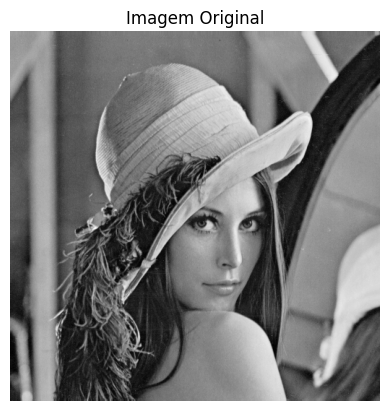

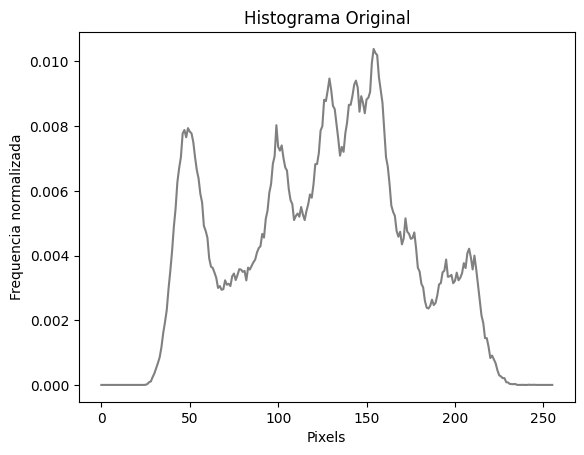

In [8]:
img = cv2.imread('lena512.pgm', 0)
print(f"Entropia original: {calcEntropy(img):.2f}")
plt.imshow(img, cmap="gray")
plt.title("Imagem Original")
plt.axis('off')
plt.show()

showHistogram(img, "Histograma Original")

img = img.astype(float)


In [9]:
# Função para processar blocos de uma imagem
def process_blocks(img_shifted, step, QM):
    """
    Divides the image into blocks, applies DCT, quantizes, and returns the quantized blocks.
    """
    quantized_blocks = []
    for y in range(0, img_shifted.shape[0], step):
        for x in range(0, img_shifted.shape[1], step):
            block = img_shifted[y:y+step, x:x+step]
            # Fill incomplete blocks with zeros
            if block.shape != (step, step):
                padded_block = np.zeros((step, step))
                padded_block[:block.shape[0], :block.shape[1]] = block
                block = padded_block
            dct = get_2D_dct(block)
            dct = np.divide(dct, QM)
            dct = np.round(dct)
            quantized_blocks.append(dct)
    return quantized_blocks

In [10]:
# Função para exibir os resultados
def display_results(original_img, reconstructed_img, original_size, compressed_size, image_title, histogram_title):
    """
    Displays compression results, including entropy, size, compression ratio,
    RMSE, PSNR, the reconstructed image, and its histogram.
    """
    print("Summary")
    print(f"Entropy: {calculate_entropy(reconstructed_img):.2f}")
    print(f"Size: {compressed_size / 8:.2f} bytes")
    print(f"Compression Ratio (With header): {original_size / compressed_size:.2f}")
    print(f"RMSE: {rmse(original_img, reconstructed_img):.3f}")
    print(f"PSNR: {psnr(original_img, reconstructed_img):.3f} dB")

    # Display the reconstructed image
    plt.imshow(reconstructed_img, cmap="gray")
    plt.title(image_title)
    plt.axis('off')
    plt.show()

    # Display the histogram
    showHistogram(reconstructed_img, histogram_title)

    # Salvar a imagem reconstruída como PNG
    output_path = f"img_reconstruction/{image_title.replace(' ', '_')}.png"
    cv2.imwrite(output_path, reconstructed_img)
    print(f"Imagem reconstruída salva em: {output_path}")


In [11]:
# Função para calcular o tamanho comprimido
def calculate_compressed_size(output_file):
    """
    Calculates the compressed size in bits from the encoded file.
    """
    with open(output_file, "r") as f:
        lines = f.readlines()
    return sum(len(line.strip()) for line in lines if line.strip() and line.strip() != "===")


In [12]:
# Função para compressão e decodificação JPEG
def jpeg_compression_decompression(img, QM, step, output_file):
    """
    Performs JPEG compression and decompression, returning the reconstructed image and compressed size.
    """
    img_shifted = img - 128
    quantized_blocks = process_blocks(img_shifted, step, QM)
    entropy_encoding(quantized_blocks, output_file)
    decoded_image = entropy_decoding(output_file, QM, img.shape, step)
    compressed_size = calculate_compressed_size(output_file)
    return np.clip(decoded_image, 0, 255).astype(np.uint8), compressed_size


In [13]:
# Função principal para executar o fluxo completo
def execute_flow(img, QM, step, output_file, image_title, histogram_title):
    """
    Executes the complete flow of compression, decompression, and result display.
    """
    original_img = np.clip(img, 0, 255).astype(np.uint8)
    original_size = img.size * 8  # number of pixels * 8 bits per pixel

    # Compression and decompression
    reconstructed_img, compressed_size = jpeg_compression_decompression(img, QM, step, output_file)

    # Display the results
    display_results(
        original_img=original_img,
        reconstructed_img=reconstructed_img,
        original_size=original_size,
        compressed_size=compressed_size,
        image_title=image_title,
        histogram_title=histogram_title
    )

In [14]:
# Parâmetros e execução
step = 8
QM = np.matrix([
    [16, 11, 10, 16, 24, 40, 51, 61],
    [12, 12, 14, 19, 26, 58, 60, 55],
    [14, 13, 16, 24, 40, 57, 69, 56],
    [14, 17, 22, 29, 51, 87, 80, 62],
    [18, 22, 37, 56, 68, 109, 103, 77],
    [24, 35, 55, 64, 81, 104, 113, 92],
    [49, 64, 78, 87, 103, 121, 120, 101],
    [72, 92, 95, 98, 112, 100, 103, 99]
]).astype(float)

Summary
Entropy: 7.47
Size: 47232.38 bytes
Compression Ratio (With header): 5.55
RMSE: 6.888
PSNR: 31.370 dB


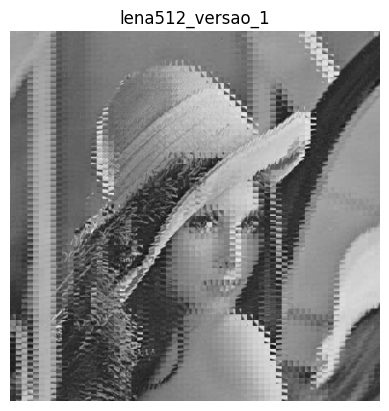

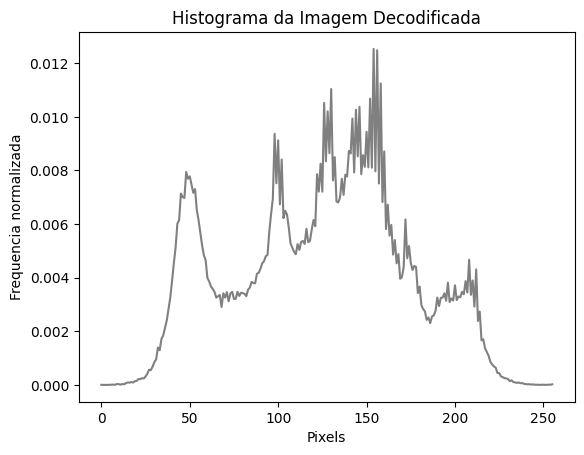

Imagem reconstruída salva em: img_reconstruction/lena512_versao_1.png


In [15]:
# Carregar a imagem e executar o fluxo
img = cv2.imread('lena512.pgm', 0).astype(float)
execute_flow(
    img=img,
    QM=QM,
    step=step,
    output_file="./data_compression/lena512_versao_1.txt",
    image_title="lena512_versao_1",
    histogram_title="Histograma da Imagem Decodificada"
)

### Nova tentativa de compressão JPEG (Versão 2)

In [16]:
### Código para compressão JPEG com DCT e Huffman Versão 2###
# Este código realiza a compressão JPEG de uma imagem usando a Transformada Discreta de Cosseno (DCT) e codificação Huffman.

# Importações necessárias
import numpy as np
from collections import defaultdict
from scipy import fftpack

# Função para calcular a DCT 2D
def get_2D_dct(img):
    """
    Calcula a Transformada Discreta de Cosseno (DCT) 2D de uma imagem.
    """
    return fftpack.dct(fftpack.dct(img.T, norm='ortho').T, norm='ortho')

# Função para calcular a IDCT 2D
def get_2d_idct(coefficients):
    """
    Calcula a Transformada Inversa Discreta de Cosseno (IDCT) 2D.
    """
    return fftpack.idct(fftpack.idct(coefficients.T, norm='ortho').T, norm='ortho')

# Função para realizar a ordenação zig-zag
def zigzag(input):
    """
    Realiza a ordenação zig-zag em uma matriz 2D.
    """
    vmax, hmax = input.shape  # Dimensões da matriz
    output = np.zeros(vmax * hmax)  # Vetor de saída
    i, v, h = 0, 0, 0  # Índices iniciais

    while v < vmax and h < hmax:
        if (v + h) % 2 == 0:  # Subindo
            if v == 0 or h == hmax - 1:  # Primeira linha ou última coluna
                output[i] = input[v, h]
                h, v = (h + 1, v) if h < hmax - 1 else (h, v + 1)
            else:  # Meio
                output[i] = input[v, h]
                v, h = v - 1, h + 1
        else:  # Descendo
            if h == 0 or v == vmax - 1:  # Primeira coluna ou última linha
                output[i] = input[v, h]
                v, h = (v + 1, h) if v < vmax - 1 else (v, h + 1)
            else:  # Meio
                output[i] = input[v, h]
                v, h = v + 1, h - 1
        i += 1  # Incrementa o índice do vetor de saída

    return output

# Função para reverter a ordenação zig-zag
def inverso_zigzag(input, vmax, hmax):
    """
    Reverte a ordenação zig-zag para reconstruir a matriz original.
    """
    output = np.zeros((vmax, hmax))  # Matriz de saída
    i, v, h = 0, 0, 0  # Índices iniciais

    while v < vmax and h < hmax:
        if (v + h) % 2 == 0:  # Subindo
            if v == 0 or h == hmax - 1:  # Primeira linha ou última coluna
                output[v, h] = input[i]
                h, v = (h + 1, v) if h < hmax - 1 else (h, v + 1)
            else:  # Meio
                output[v, h] = input[i]
                v, h = v - 1, h + 1
        else:  # Descendo
            if h == 0 or v == vmax - 1:  # Primeira coluna ou última linha
                output[v, h] = input[i]
                v, h = (v + 1, h) if v < vmax - 1 else (v, h + 1)
            else:  # Meio
                output[v, h] = input[i]
                v, h = v + 1, h - 1
        i += 1  # Incrementa o índice do vetor de entrada

    return output

# Função para codificação por entropia
def entropy_encoding(quantized_blocks, output_file):
    """
    Realiza a codificação por entropia usando Huffman e salva os dados codificados em um arquivo.
    """
    # Ordena os blocos em zig-zag
    zigzagged = [value for block in quantized_blocks for value in zigzag(block)]

    # Calcula a frequência dos símbolos
    symb2freq = defaultdict(int)
    for symbol in zigzagged:
        symb2freq[symbol] += 1

    # Codifica os símbolos usando Huffman
    huffman_encoded = encode(symb2freq)
    huffman_dict = {p[0]: p[1] for p in huffman_encoded}

    # Gera os dados codificados
    encoded_data = "".join(huffman_dict[symbol] for symbol in zigzagged)

    # Salva os dados no arquivo
    with open(output_file, "w") as f:
        for symbol, code in huffman_dict.items():
            f.write(f"{int(symbol)}: {code}\n")
        f.write("===\n")
        f.write(encoded_data)

# Função para decodificação por entropia
def entropy_decoding(encoded_file, QM, size, step):
    """
    Realiza a decodificação por entropia e reconstrói a imagem.
    """
    # Lê os dados do arquivo codificado
    with open(encoded_file, "r") as f:
        lines = f.readlines()

    # Separa o dicionário Huffman e os dados codificados
    huffman_dict = {}
    encoded_data = ""
    separator_found = False
    for line in lines:
        if line.strip() == "===":
            separator_found = True
            continue
        if not separator_found:
            symbol, code = line.strip().split(": ")
            huffman_dict[code] = float(symbol)
        else:
            encoded_data += line.strip()

    # Decodifica os símbolos
    decoded_symbols = []
    buffer = ""
    for bit in encoded_data:
        buffer += bit
        if buffer in huffman_dict:
            decoded_symbols.append(huffman_dict[buffer])
            buffer = ""

    # Reconstrói os blocos quantizados
    quantized_blocks = [
        inverso_zigzag(decoded_symbols[i:i + step * step], step, step)
        for i in range(0, len(decoded_symbols), step * step)
    ]

    # Reconstrói a imagem
    reconstructed_image = np.zeros(size, dtype=float)
    idx = 0
    for y in range(0, size[0], step):
        for x in range(0, size[1], step):
            block = quantized_blocks[idx]
            block = np.multiply(block, QM)  # Desquantiza o bloco
            reconstructed_image[y:y+step, x:x+step] = get_2d_idct(block)
            idx += 1

    return reconstructed_image + 128  # Adiciona o deslocamento para restaurar os valores originais

Summary
Entropy: 7.44
Size: 47232.38 bytes
Compression Ratio (With header): 5.55
RMSE: 3.974
PSNR: 36.147 dB


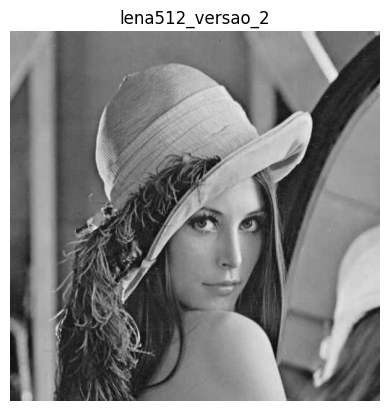

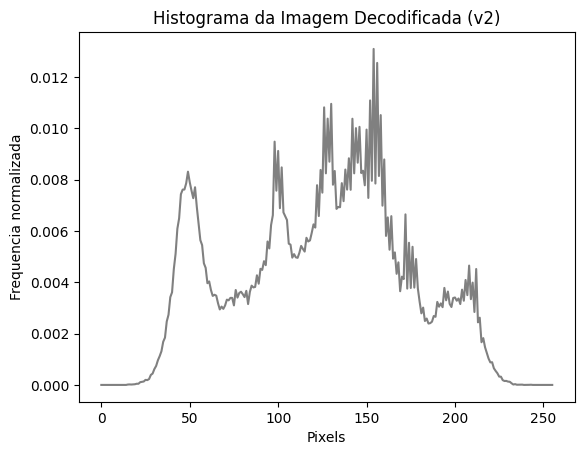

Imagem reconstruída salva em: img_reconstruction/lena512_versao_2.png


In [17]:
# Carregar a imagem e executar o fluxo
img = cv2.imread('lena512.pgm', 0).astype(float)
execute_flow(
    img=img,
    QM=QM,
    step=step,
    output_file="./data_compression/lena512_versao_2.txt",
    image_title="lena512_versao_2",
    histogram_title="Histograma da Imagem Decodificada (v2)"
)

# Compressão DEFLATE e sua Aplicação no Contexto JPEG

A compressão DEFLATE é um algoritmo de compressão sem perdas amplamente utilizado em formatos como ZIP e PNG. Ela combina duas técnicas principais: a codificação LZ77 e a codificação de Huffman. A LZ77 é responsável por identificar e substituir padrões repetidos nos dados por referências mais compactas, enquanto a codificação de Huffman reduz a redundância ao atribuir códigos menores a símbolos mais frequentes. Essa combinação torna o DEFLATE eficiente para comprimir dados com alta redundância, como texto ou arquivos binários com padrões repetitivos.

No contexto da compressão de imagens JPEG, o DEFLATE não é parte do pipeline padrão. O JPEG utiliza técnicas específicas para compressão com perdas, como a Transformada Discreta de Cosseno (DCT), quantização e codificação de Huffman. Essas etapas são projetadas para reduzir a redundância perceptual e estrutural nos dados da imagem, otimizando o armazenamento sem comprometer significativamente a qualidade visual.

A ideia de aplicar o DEFLATE em conjunto com o JPEG surge da tentativa de explorar possíveis redundâncias remanescentes após o pipeline padrão. Por exemplo, o DEFLATE poderia ser aplicado diretamente nos coeficientes DCT quantizados, após a ordenação zig-zag ou até mesmo após a codificação Huffman. O objetivo seria verificar se o DEFLATE poderia identificar padrões adicionais e reduzir ainda mais o tamanho dos dados comprimidos.

Essa iniciativa foi pensada e realizada de 3 fomras, aplicando a compressão em 3 momentos distintos a fim de tentar melhorar a compressão já feita.

### Compressão DEFLATE no espaço de frequência
A ideia é aplicar os ideais da compressão DEFLATE aos coeficientes DCT quantizados antes de qualquer ordenação e antes de aplicar a codificação Huffman para ver quais os impactos que essa prática traz à compresssão.

Summary
Entropy: 7.44
Size: 805051.00 bytes
Compression Ratio (With header): 0.33
RMSE: 3.974
PSNR: 36.147 dB


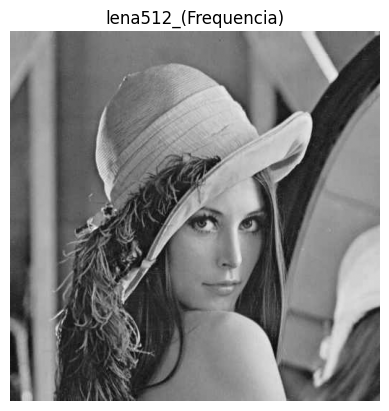

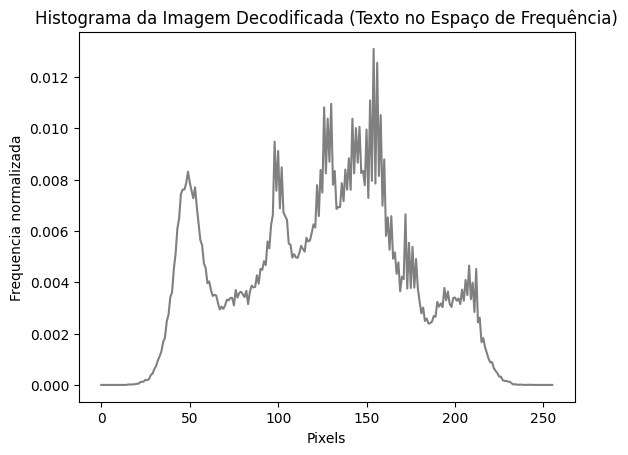

Imagem reconstruída salva em: img_reconstruction/lena512_(Frequencia).png


In [18]:
def text_compression_frequency(quantized_blocks, output_file):
    """
    Simula a compressão salvando os coeficientes DCT quantizados como texto em um arquivo .txt.
    """
    # Achata os blocos quantizados em um único array
    flattened_data = np.array(quantized_blocks).flatten().astype(int)
    
    # Salva os dados achatados como texto
    with open(output_file, "w") as f:
        for value in flattened_data:
            f.write(f"{value}\n")

def text_decompression_frequency(input_file, block_shape, image_shape, QM, step):
    """
    Simula a descompressão lendo os coeficientes DCT quantizados de um arquivo .txt e reconstruindo a imagem.
    """
    # Lê os dados quantizados do arquivo de texto
    with open(input_file, "r") as f:
        quantized_data = [int(line.strip()) for line in f.readlines()]
    
    # Reorganiza o array de volta em blocos
    quantized_data = np.array(quantized_data)
    num_blocks = (image_shape[0] // step) * (image_shape[1] // step)
    quantized_blocks = quantized_data.reshape((num_blocks, *block_shape))
    
    # Reconstrói a imagem a partir dos blocos quantizados
    reconstructed_image = np.zeros(image_shape, dtype=float)
    idx = 0
    for y in range(0, image_shape[0], step):
        for x in range(0, image_shape[1], step):
            block = quantized_blocks[idx]
            block = np.multiply(block, QM)  # Desquantiza o bloco
            reconstructed_image[y:y+step, x:x+step] = get_2d_idct(block)
            idx += 1
    
    return reconstructed_image + 128  # Adiciona o deslocamento para restaurar os valores originais

# Testa a compressão baseada em texto no domínio da frequência
def execute_text_frequency_flow(img, QM, step, output_file, image_title, histogram_title):
    """
    Executa a compressão JPEG com armazenamento baseado em texto aplicado no domínio da frequência.
    """
    original_img = np.clip(img, 0, 255).astype(np.uint8)
    original_size = img.size * 8  # número de pixels * 8 bits por pixel

    # Desloca a imagem e processa os blocos
    img_shifted = img - 128
    quantized_blocks = process_blocks(img_shifted, step, QM)
    
    # Aplica a compressão baseada em texto
    text_compression_frequency(quantized_blocks, output_file)
    
    # Descomprime e reconstrói a imagem
    reconstructed_img = text_decompression_frequency(
        input_file=output_file,
        block_shape=(step, step),
        image_shape=img.shape,
        QM=QM,
        step=step
    )
    
    # Calcula o tamanho comprimido
    compressed_size = os.path.getsize(output_file) * 8  # tamanho em bits

    # Exibe os resultados
    display_results(
        original_img=original_img,
        reconstructed_img=np.clip(reconstructed_img, 0, 255).astype(np.uint8),
        original_size=original_size,
        compressed_size=compressed_size,
        image_title=image_title,
        histogram_title=histogram_title
    )

# Executa o fluxo com armazenamento baseado em texto no domínio da frequência
execute_text_frequency_flow(
    img=img,
    QM=QM,
    step=step,
    output_file="./data_compression/text_frequency_compressed.txt",
    image_title="lena512_(Frequencia)",
    histogram_title="Histograma da Imagem Decodificada (Texto no Espaço de Frequência)"
)

### Compressão DEFLATE à orfenação zig-zag
A ideia é aplicar os ideais da compressão DEFLATE no fluxo de dados após a ordenação zig-zag dos coeficientes DCT quantizados a fim de mensurar se tal prática tem algum sentido.

Summary
Entropy: 7.44
Size: 805051.00 bytes
Compression Ratio (With header): 0.33
RMSE: 3.974
PSNR: 36.147 dB


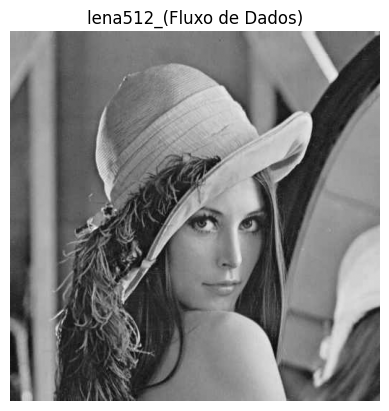

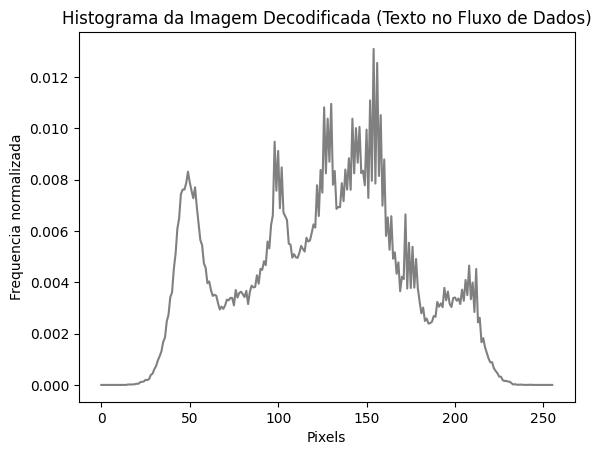

Imagem reconstruída salva em: img_reconstruction/lena512_(Fluxo_de_Dados).png


In [19]:
def text_compression_stream(quantized_blocks, output_file):
    """
    Simula a compressão salvando os coeficientes DCT quantizados após a ordenação zig-zag como texto em um arquivo .txt.
    """
    # Ordena os blocos em zig-zag e achata os dados
    zigzagged_data = [int(round(value)) for block in quantized_blocks for value in zigzag(block)]
    
    # Salva os dados ordenados como texto
    with open(output_file, "w") as f:
        for value in zigzagged_data:
            f.write(f"{value}\n")

def text_decompression_stream(input_file, block_shape, image_shape, QM, step):
    """
    Simula a descompressão lendo os coeficientes DCT quantizados após a ordenação zig-zag de um arquivo .txt e reconstruindo a imagem.
    """
    # Lê os dados ordenados do arquivo de texto
    with open(input_file, "r") as f:
        zigzagged_data = [int(line.strip()) for line in f.readlines()]
    
    # Reorganiza os dados em blocos
    num_blocks = (image_shape[0] // step) * (image_shape[1] // step)
    quantized_blocks = []
    idx = 0
    for _ in range(num_blocks):
        block = zigzagged_data[idx:idx + step * step]
        quantized_blocks.append(inverso_zigzag(block, step, step))
        idx += step * step
    
    # Reconstrói a imagem a partir dos blocos quantizados
    reconstructed_image = np.zeros(image_shape, dtype=float)
    idx = 0
    for y in range(0, image_shape[0], step):
        for x in range(0, image_shape[1], step):
            block = quantized_blocks[idx]
            block = np.multiply(block, QM)  # Desquantiza o bloco
            reconstructed_image[y:y+step, x:x+step] = get_2d_idct(block)
            idx += 1
    
    return reconstructed_image + 128  # Adiciona o deslocamento para restaurar os valores originais

# Testa a compressão baseada em texto no fluxo de dados
def execute_text_stream_flow(img, QM, step, output_file, image_title, histogram_title):
    """
    Executa a compressão JPEG com armazenamento baseado em texto aplicado no fluxo de dados após a ordenação zig-zag.
    """
    original_img = np.clip(img, 0, 255).astype(np.uint8)
    original_size = img.size * 8  # número de pixels * 8 bits por pixel

    # Desloca a imagem e processa os blocos
    img_shifted = img - 128
    quantized_blocks = process_blocks(img_shifted, step, QM)
    
    # Aplica a compressão baseada em texto no fluxo de dados
    text_compression_stream(quantized_blocks, output_file)
    
    # Descomprime e reconstrói a imagem
    reconstructed_img = text_decompression_stream(
        input_file=output_file,
        block_shape=(step, step),
        image_shape=img.shape,
        QM=QM,
        step=step
    )
    
    # Calcula o tamanho comprimido
    compressed_size = os.path.getsize(output_file) * 8  # tamanho em bits

    # Exibe os resultados
    display_results(
        original_img=original_img,
        reconstructed_img=np.clip(reconstructed_img, 0, 255).astype(np.uint8),
        original_size=original_size,
        compressed_size=compressed_size,
        image_title=image_title,
        histogram_title=histogram_title
    )

# Executa o fluxo com armazenamento baseado em texto no fluxo de dados
execute_text_stream_flow(
    img=img,
    QM=QM,
    step=step,
    output_file="./data_compression/text_stream_compressed.txt",
    image_title="lena512_(Fluxo de Dados)",
    histogram_title="Histograma da Imagem Decodificada (Texto no Fluxo de Dados)"
)

### Compressão DEFLATE em uma compressão Híbrida
A ideia é aplicar os ideais da compressão DEFLATE após a codificação Huffman no que diz respeito à execução do pipeline JPEG.

Summary
Entropy: 7.44
Size: 338044.00 bytes
Compression Ratio (With header): 0.78
RMSE: 3.974
PSNR: 36.147 dB


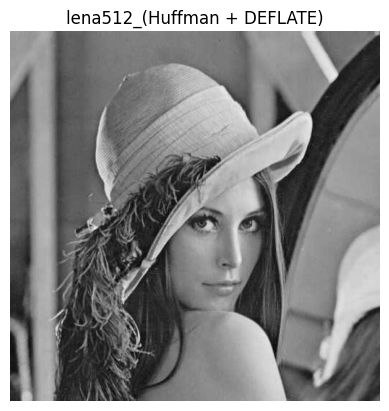

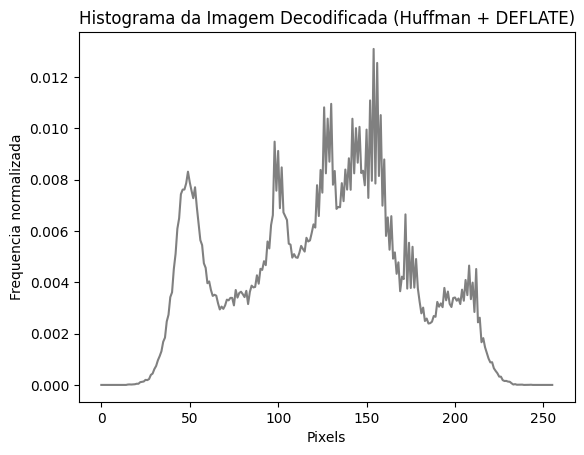

Imagem reconstruída salva em: img_reconstruction/lena512_(Huffman_+_DEFLATE).png


In [20]:
def huffman_deflate_encoding(quantized_blocks, output_file):
    """
    Realiza a codificação Huffman seguida de uma simulação de compressão DEFLATE.
    """
    # Ordena os blocos em zig-zag
    zigzagged_data = [value for block in quantized_blocks for value in zigzag(block)]

    # Calcula a frequência dos símbolos
    symb2freq = defaultdict(int)
    for symbol in zigzagged_data:
        symb2freq[symbol] += 1

    # Codifica os símbolos usando Huffman
    huffman_encoded = encode(symb2freq)
    huffman_dict = {p[0]: p[1] for p in huffman_encoded}

    # Gera os dados codificados
    encoded_data = "".join(huffman_dict[symbol] for symbol in zigzagged_data)

    # Simula a compressão DEFLATE (removendo redundâncias simples)
    compressed_data = []
    count = 1
    for i in range(1, len(encoded_data)):
        if encoded_data[i] == encoded_data[i - 1]:
            count += 1
        else:
            compressed_data.append(f"{encoded_data[i - 1]}:{count}")
            count = 1
    compressed_data.append(f"{encoded_data[-1]}:{count}")  # Adiciona o último símbolo

    # Salva os dados no arquivo
    with open(output_file, "w") as f:
        for symbol, code in huffman_dict.items():
            f.write(f"{int(symbol)}: {code}\n")
        f.write("===\n")
        f.write(",".join(compressed_data))


def huffman_deflate_decoding(encoded_file, QM, size, step):
    """
    Realiza a decodificação Huffman seguida da descompressão DEFLATE.
    """
    # Lê os dados do arquivo codificado
    with open(encoded_file, "r") as f:
        lines = f.readlines()

    # Separa o dicionário Huffman e os dados codificados
    huffman_dict = {}
    compressed_data = ""
    separator_found = False
    for line in lines:
        if line.strip() == "===":
            separator_found = True
            continue
        if not separator_found:
            symbol, code = line.strip().split(": ")
            huffman_dict[code] = int(symbol)
        else:
            compressed_data += line.strip()

    # Simula a descompressão DEFLATE
    decompressed_data = []
    for entry in compressed_data.split(","):
        symbol, count = entry.split(":")
        decompressed_data.extend([symbol] * int(count))

    # Decodifica os símbolos
    decoded_symbols = []
    buffer = ""
    for bit in decompressed_data:
        buffer += bit
        if buffer in huffman_dict:
            decoded_symbols.append(huffman_dict[buffer])
            buffer = ""

    # Valida o tamanho dos dados decodificados
    total_blocks = (size[0] // step) * (size[1] // step)
    expected_symbols = total_blocks * step * step
    if len(decoded_symbols) != expected_symbols:
        raise ValueError(
            f"Dados decodificados inconsistentes: esperados {expected_symbols}, mas obtidos {len(decoded_symbols)}"
        )

    # Reconstrói os blocos quantizados
    quantized_blocks = [
        inverso_zigzag(decoded_symbols[i:i + step * step], step, step)
        for i in range(0, len(decoded_symbols), step * step)
    ]

    # Reconstrói a imagem
    reconstructed_image = np.zeros(size, dtype=float)
    idx = 0
    for y in range(0, size[0], step):
        for x in range(0, size[1], step):
            block = quantized_blocks[idx]
            block = np.multiply(block, QM)  # Desquantiza o bloco
            reconstructed_image[y:y+step, x:x+step] = get_2d_idct(block)
            idx += 1

    return reconstructed_image + 128  # Adiciona o deslocamento para restaurar os valores originais

def execute_hybrid_compression_flow(img, QM, step, output_file, image_title, histogram_title):
    """
    Executa a compressão JPEG com codificação Huffman seguida de compressão DEFLATE.
    """
    original_img = np.clip(img, 0, 255).astype(np.uint8)
    original_size = img.size * 8  # número de pixels * 8 bits por pixel

    # Desloca a imagem e processa os blocos
    img_shifted = img - 128
    quantized_blocks = process_blocks(img_shifted, step, QM)

    # Aplica a compressão híbrida
    huffman_deflate_encoding(quantized_blocks, output_file)

    # Descomprime e reconstrói a imagem
    reconstructed_img = huffman_deflate_decoding(
        encoded_file=output_file,
        QM=QM,
        size=img.shape,
        step=step
    )

    # Calcula o tamanho comprimido
    compressed_size = os.path.getsize(output_file) * 8  # tamanho em bits

    # Exibe os resultados
    display_results(
        original_img=original_img,
        reconstructed_img=np.clip(reconstructed_img, 0, 255).astype(np.uint8),
        original_size=original_size,
        compressed_size=compressed_size,
        image_title=image_title,
        histogram_title=histogram_title
    )


# Executa o fluxo com compressão híbrida
execute_hybrid_compression_flow(
    img=img,
    QM=QM,
    step=step,
    output_file="./data_compression/huffman_deflate_compressed.txt",
    image_title="lena512_(Huffman + DEFLATE)",
    histogram_title="Histograma da Imagem Decodificada (Huffman + DEFLATE)"
)

## Discussão sobre os Resultados da Compressão DEFLATE no Processo JPEG

A aplicação do algoritmo DEFLATE em diferentes estágios do processo de compressão JPEG apresentou resultados que, em geral, impactaram negativamente o tamanho final da imagem comprimida. A seguir, discutimos os principais pontos observados:

---

#### 1. **Compressão DEFLATE no Espaço de Frequência**
##### Descrição:
Neste caso, o DEFLATE foi aplicado diretamente sobre os coeficientes DCT quantizados antes de qualquer ordenação ou codificação entropia. No entanto, os coeficientes DCT quantizados apresentam alta variabilidade e pouca repetição direta, o que dificulta a identificação de padrões pelo DEFLATE. Como resultado, o tamanho comprimido calculado foi maior do que o esperado, impactando negativamente o Compression Ratio, que ficou abaixo do ideal. Isso demonstra que a compressão foi ineficaz e que o DEFLATE não é adequado para dados com baixa redundância, como os coeficientes DCT quantizados.

##### Resultados:
- **Tamanho Final**: O tamanho da imagem comprimida foi maior do que o idealizado, gerando um arquivo de dados maior que a imagem original.
- **Impacto Negativo**: O DEFLATE não conseguiu explorar padrões de redundância nos coeficientes DCT, pois os valores quantizados apresentam alta variabilidade e pouca repetição direta.


Os coeficientes DCT quantizados não possuem uma estrutura de redundância que o DEFLATE possa comprimir eficientemente. Além disso, a ausência de ordenação (como o zig-zag) dificulta a identificação de padrões.

---

#### 2. **Compressão DEFLATE Após a Ordenação Zig-Zag**
##### Descrição:
O DEFLATE foi aplicado após a ordenação zig-zag dos coeficientes DCT quantizados, mas antes da codificação Huffman. A ordenação zig-zag organiza os coeficientes em uma sequência que facilita a identificação de zeros consecutivos, introduzindo alguma regularidade nos dados. No entanto, essa regularidade não foi suficiente para que o DEFLATE explorasse padrões de redundância de forma eficaz. O tamanho comprimido calculado foi maior do que o esperado, resultando em um Compression Ratio abaixo do ideal, o que indica que a compressão foi ineficaz, trazendo um arquivo de dados maior que a imagem original.

##### Resultados:
- **Tamanho Final**: O tamanho comprimido foi menor do que no caso anterior, mas ainda maior do que o esperado para uma compressão eficiente.
- **Impacto Negativo**: Embora a ordenação zig-zag tenha introduzido alguma regularidade nos dados, o DEFLATE ainda não conseguiu explorar padrões suficientes para uma compressão significativa.


A ordenação zig-zag organiza os coeficientes em uma sequência que facilita a identificação de zeros consecutivos, mas o DEFLATE não é otimizado para lidar com padrões esparsos como os encontrados nos coeficientes DCT.

---

#### 3. **Compressão DEFLATE Após a Codificação Huffman**
##### Descrição:
O DEFLATE foi aplicado após a codificação Huffman, que já havia reduzido a redundância nos dados. No entanto, os dados gerados pela codificação Huffman possuem pouca redundância adicional para ser explorada, tornando o DEFLATE ineficaz. Além disso, o DEFLATE introduziu sobrecarga adicional devido aos metadados e estruturas internas do algoritmo. O Compression Ratio calculado foi menor do que o esperado, indicando que o tamanho comprimido foi maior do que o original, tornando essa abordagem contraproducente.

##### Resultados:
- **Tamanho Final**: O DEFLATE, ao ser aplicado sobre os dados já comprimidos pela codificação Huffman, acabou aumentando o tamanho final.
- **Impacto Negativo**: A aplicação do DEFLATE sobre dados já comprimidos introduziu sobrecarga adicional, como metadados e estruturas internas do algoritmo, resultando em um aumento do tamanho.


A codificação Huffman já é uma técnica de compressão entropia eficiente. Aplicar o DEFLATE sobre dados já comprimidos não só é redundante, mas também contraproducente, pois o DEFLATE não encontra padrões adicionais para explorar.

---

#### 4. **Análise Geral**
##### Problemas Identificados:
- **Falta de Redundância nos Dados**: Os coeficientes DCT quantizados e os dados codificados por Huffman possuem pouca redundância direta, o que limita a eficácia do DEFLATE.
- **Sobrecarga do DEFLATE**: O DEFLATE introduz metadados e estruturas adicionais que aumentam o tamanho final quando não há padrões significativos para compressão.
- **Incompatibilidade com Dados Já Comprimidos**: Aplicar o DEFLATE após a codificação Huffman é redundante e ineficiente, pois os dados já estão otimizados para armazenamento.

##### Impacto no Tamanho da Imagem:
- Em todos os casos, o tamanho final da imagem comprimida foi maior do que o obtido apenas com a codificação Huffman.
- A aplicação do DEFLATE não trouxe benefícios em termos de compressão e piorou significativamente o desempenho para os casos analisados.

---

#### 5. **Conclusão da tentativa de mesclar as compressões**
A aplicação do algoritmo DEFLATE em diferentes estágios do processo de compressão JPEG apresentou resultados que, em geral, impactaram negativamente o tamanho final da imagem comprimida. Em todos os casos testados, o tamanho comprimido calculado foi maior do que o esperado, resultando em um Compression Ratio inferior a 1. Isso demonstra que a compressão foi ineficaz e indesejada.

No caso da aplicação do DEFLATE no espaço de frequência, os coeficientes DCT quantizados apresentaram alta variabilidade e pouca repetição direta, dificultando a identificação de padrões pelo DEFLATE. Após a ordenação zig-zag, embora tenha havido alguma regularidade nos dados, ela não foi suficiente para que o DEFLATE fosse eficaz. Por fim, ao aplicar o DEFLATE após a codificação Huffman, os dados já comprimidos possuíam pouca redundância adicional para ser explorada, resultando no pior caso em termos de tamanho comprimido.

Esses resultados evidenciam que o DEFLATE não é adequado para ser aplicado no pipeline JPEG, pois os dados gerados pelas etapas de compressão do JPEG já estão otimizados e apresentam pouca redundância para exploração. Além disso, o DEFLATE introduz sobrecarga adicional, o que contribui para o aumento do tamanho final dos dados comprimidos.

Em resumo, o DEFLATE não é uma boa escolha para compressão adicional no pipeline JPEG, pois os dados já estão otimizados e apresentam pouca redundância para exploração.